# Look at hyperoptimization results for BioWTA modifications

In [1]:
import h5py
import gc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from typing import Sequence, Union, Tuple, Optional

from tqdm.notebook import tqdm
from bioslds.hdf import read_namespace_hierarchy
from bioslds.plotting import FigureManager, colorbar

In [2]:
fig_path = os.path.join("..", "..", "figs", "draft")
paper_style = [
    "seaborn-paper",
    {"font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 6, "ytick.labelsize": 6},
]

## Useful definitions

In [3]:
def make_two_param_plot(
    ax: plt.Axes,
    values: dict,
    key1: str,
    key2: str,
    log1: bool = False,
    log2: bool = False,
    mask: Union[None, slice, Sequence] = None,
    fct_key: str = "fct",
    vmin: float = 0.5,
    vmax: float = 1.0,
):
    # make the scatter plot
    if mask is None:
        mask = slice(None, None)
    h = ax.scatter(
        values[key1][mask],
        values[key2][mask],
        c=values[fct_key][mask],
        cmap="Reds",
        vmin=vmin,
        vmax=vmax,
        alpha=0.3,
        ec=None,
    )

    ax.set_xlabel(key1)
    ax.set_ylabel(key2)

    if log1:
        ax.set_xscale("log")
    if log2:
        ax.set_yscale("log")

    ax.set_xlim(np.min(all_values[key1]), np.max(all_values[key1]))
    ax.set_ylim(np.min(all_values[key2]), np.max(all_values[key2]))

    colorbar(h)

In [4]:
def make_summary_figure(
    values: dict,
    fct_key: str = "fct",
    top_fraction: float = 0.01,
    log_scale: Optional[Sequence] = None,
    vmin: float = 0.5,
    vmax: float = 1.0,
) -> Tuple[plt.Figure, Sequence]:
    if log_scale is None:
        log_scale = []

    # keep only the keys that have some variation and are not scores
    keys = [
        key
        for key in values.keys()
        if not key.startswith("fct") and np.std(values[key]) > 0
    ]

    # identify the top 5% highest scores
    scores = values[fct_key]

    n = len(scores)
    n_highscore = max(1, int(np.round(top_fraction * n)))
    highscore_idxs = np.argsort(scores)[-n_highscore:]
    highscores = scores[highscore_idxs]

    # make the figure
    n_keys = len(keys)
    with plt.style.context(paper_style):
        with FigureManager(
            n_keys,
            n_keys,
            squeeze=False,
            figsize=(5.76, 3 * 5.76 / 4),
            despine_kws={"offset": 5},
        ) as (fig, axs):
            # draw histograms on the diagonal
            for i in range(n_keys):
                ax = axs[i, i]

                crt_values = values[keys[i]]
                sns.histplot(
                    crt_values,
                    element="step",
                    stat="density",
                    alpha=0.2,
                    color="gray",
                    log_scale=keys[i] in log_scale,
                    label="all random trials",
                    ax=ax,
                )

                # now draw the high-scoring values
                crt_highscore_values = crt_values[highscore_idxs]
                sns.kdeplot(
                    crt_highscore_values,
                    color="C1",
                    log_scale=keys[i] in log_scale,
                    shade=True,
                    label=f"best {int(top_fraction * 100)}%",
                    ax=ax,
                )
                sns.rugplot(
                    crt_highscore_values, height=0.05, c="C1", lw=0.5, ax=ax,
                )

                ax.legend(frameon=False, fontsize=6, loc="upper left")
                ax.set_xlabel(keys[i])
                ax.set_ylabel("pdf")

                ax.set_xlim(np.min(crt_values), np.max(crt_values))

            # now the off-diagonals
            for i in range(n_keys):
                crt_values1 = values[keys[i]]
                crt_highscore_values1 = crt_values1[highscore_idxs]
                for j in range(n_keys):
                    if j == i:
                        continue

                    crt_values2 = values[keys[j]]
                    crt_highscore_values2 = crt_values2[highscore_idxs]

                    ax = axs[j, i]

                    h = ax.scatter(
                        crt_values1,
                        crt_values2,
                        c=scores,
                        cmap="Greys",
                        vmin=vmin,
                        vmax=vmax,
                        alpha=0.2,
                        ec=None,
                    )

                    # now the high-scoring set
                    h = ax.scatter(
                        crt_highscore_values1,
                        crt_highscore_values2,
                        c=highscores,
                        cmap="Reds",
                        vmin=vmin,
                        # vmax=np.max(highscores),
                        alpha=0.7,
                        ec=None,
                    )

                    ax.set_xlabel(keys[i])
                    ax.set_ylabel(keys[j])

                    if keys[i] in log_scale:
                        ax.set_xscale("log")
                    if keys[j] in log_scale:
                        ax.set_yscale("log")

                    ax.set_xlim(np.min(crt_values1), np.max(crt_values1))
                    ax.set_ylim(np.min(crt_values2), np.max(crt_values2))

    return fig, axs

In [5]:
def make_optimal_parameter_figure(
    values: dict,
    fct_key: Union[str, Sequence] = "fct",
    top_fraction: float = 0.01,
    log_scale: Optional[Sequence] = None,
) -> Tuple[plt.Figure, Sequence]:
    if log_scale is None:
        log_scale = []

    if isinstance(fct_key, str):
        fct_key = [fct_key]

    # keep only the keys that have some variation and are not scores
    keys = [
        key
        for key in values.keys()
        if not key.startswith("fct") and np.std(values[key]) > 0
    ]

    # make the figure
    n_keys = len(keys)
    with FigureManager(n_keys, len(fct_key), squeeze=False) as (fig, axs):
        for k, crt_key in enumerate(fct_key):
            ax_col = axs[:, k]

            scores = values[crt_key]
            n = len(scores)
            n_highscore = max(1, int(np.round(top_fraction * n)))

            score_order = np.argsort(scores)[::-1]
            ordered_scores = scores[score_order]
            score_estimate = np.cumsum(ordered_scores) / np.arange(1, n + 1)

            for i in range(n_keys):
                ax = ax_col[i]

                crt_values = values[keys[i]]

                if keys[i] not in log_scale:
                    crt_cum_estimate = np.cumsum(crt_values[score_order]) / np.arange(
                        1, n + 1
                    )
                else:
                    crt_cum_estimate = np.exp(
                        np.cumsum(np.log(crt_values[score_order])) / np.arange(1, n + 1)
                    )

                ax.plot(score_estimate, crt_cum_estimate)

                ax.set_xlabel(f"average score ({crt_key})")
                ax.set_ylabel(keys[i])

                if keys[i] in log_scale:
                    ax.set_yscale("log")

                # annotate the `top_fraction` estimate
                crt_len = 0.25 * np.diff(ax.get_xlim())[0]
                crt_top_estimate = crt_cum_estimate[n_highscore]
                ax.plot(
                    np.asarray([-crt_len, 0]) + 2 * [ax.get_xlim()[1]],
                    2 * [crt_top_estimate],
                    "--",
                    c="C1",
                    label=f"best {keys[i]} = {crt_top_estimate:.3g}",
                )

                ax.legend(frameon=False)

                ax_col[0].set_title(crt_key)
                
                ax.set_ylim(np.min(crt_values), np.max(crt_values))

    return fig, axs

## Data loading

In [6]:
# use_temp, use_streak, use_timescale
# [HS] [RC] [IA] <-- hard vs. soft, random vs. continuous, instantaneous vs. average

# examples: plain = HRI, full = SCA

In [7]:
configurations = {
    (use_temp, use_streak, use_timescale): "HS"[use_temp]
    + "RC"[use_streak]
    + "IA"[use_timescale]
    for use_temp in range(2)
    for use_streak in range(2)
    for use_timescale in range(2)
}
configurations_human = {
    (0, 0, 0): "plain",
    (0, 0, 1): "avg_error",
    (0, 1, 0): "persistent",
    (1, 0, 0): "soft",
    (0, 1, 1): "persistent+avg_error",
    (1, 1, 0): "soft+persistent",
    (1, 0, 1): "soft+avg_error",
    (1, 1, 1): "full",
}

In [8]:
quantile_choice = 0.05
good_threshold = 0.85

start_seed = 100
n_seeds = 40
batch_path = os.path.join("..", "..", "batch", "biowta_ar3_mods")

results = {}
pbar = tqdm(total=len(configurations) * n_seeds)
for use_temp in range(2):
    for use_streak in range(2):
        for use_timescale in range(2):
            mod_str = "".join(str(_) for _ in [use_temp, use_streak, use_timescale])
            crt_dict = {"fct": [], "fct_quantile": [], "fct_good": []}
            for crt_seed in range(start_seed, start_seed + n_seeds):
                # load the data
                fname = os.path.join(batch_path, f"test_mod{mod_str}_{crt_seed}.hdf5")
                with h5py.File(fname, "r") as f:
                    crt_res = read_namespace_hierarchy(f)

                # initialize parameter lists
                if crt_seed == start_seed:
                    crt_dict.update({key: [] for key in crt_res["params"][0].keys()})

                # process and keep the relevant parts of the data
                for key in crt_dict:
                    if key not in ["fct", "fct_quantile", "fct_good"]:
                        crt_values = [_[key] for _ in crt_res["params"]]
                        crt_dict[key].extend(crt_values)

                # now update some special values:
                # median scrore
                crt_dict["fct"].extend(crt_res["fct_scalar"])

                # quantile score
                for crt_eval in crt_res["fct_full"]:
                    crt_quant = np.quantile(crt_eval[1].trial_scores, quantile_choice)
                    crt_dict["fct_quantile"].append(crt_quant)

                # fraction of "good" runs
                for crt_eval in crt_res["fct_full"]:
                    crt_good = np.mean(crt_eval[1].trial_scores >= good_threshold)
                    crt_dict["fct_good"].append(crt_good)

                pbar.update(1)

            # ensure everything is a Numpy array
            for key in crt_dict:
                crt_dict[key] = np.asarray(crt_dict[key])

            # store the results
            results[(use_temp, use_streak, use_timescale)] = crt_dict

            # ensure we don't keep too much useless stuff in memory
            del f
            del crt_res
            del crt_eval
            gc.collect()

pbar.close()

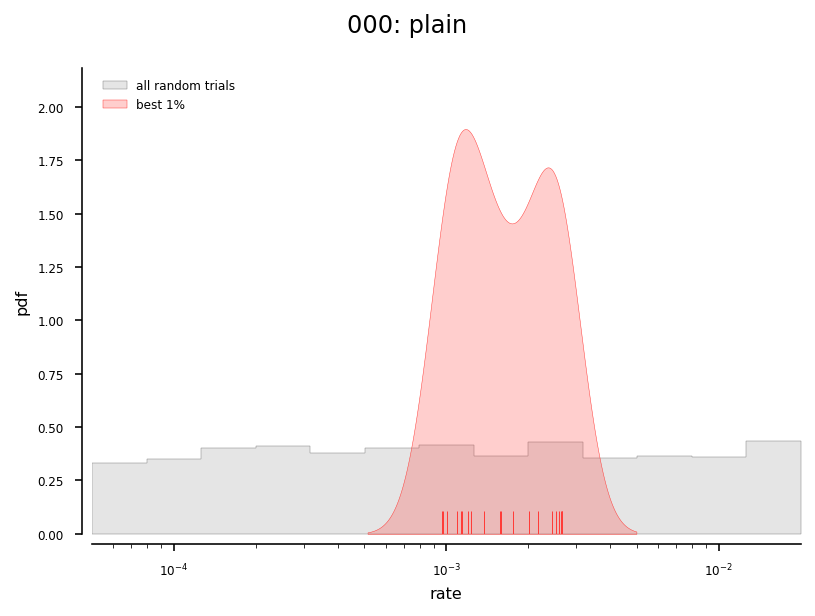

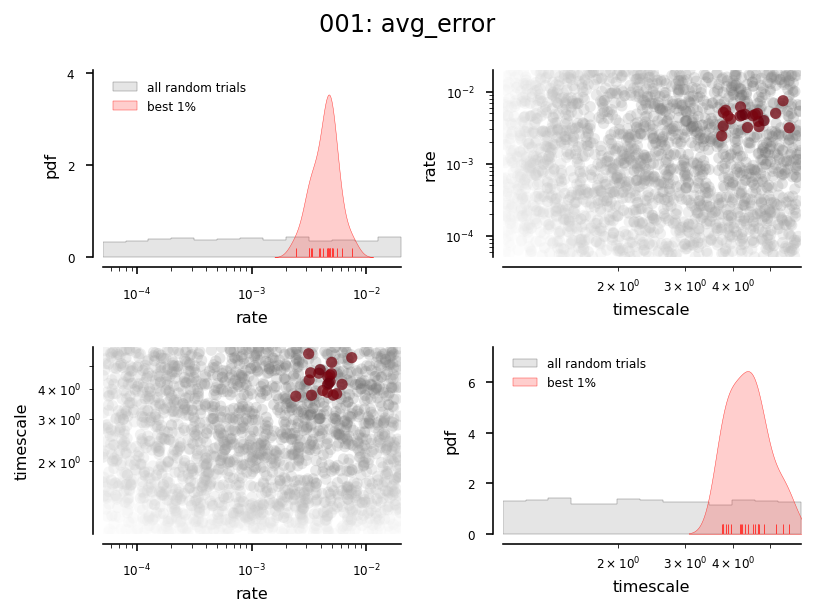

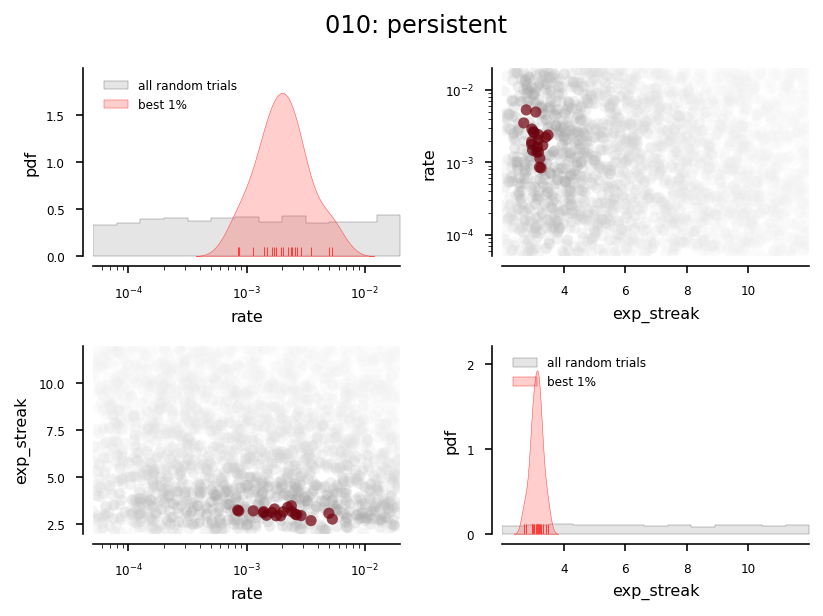

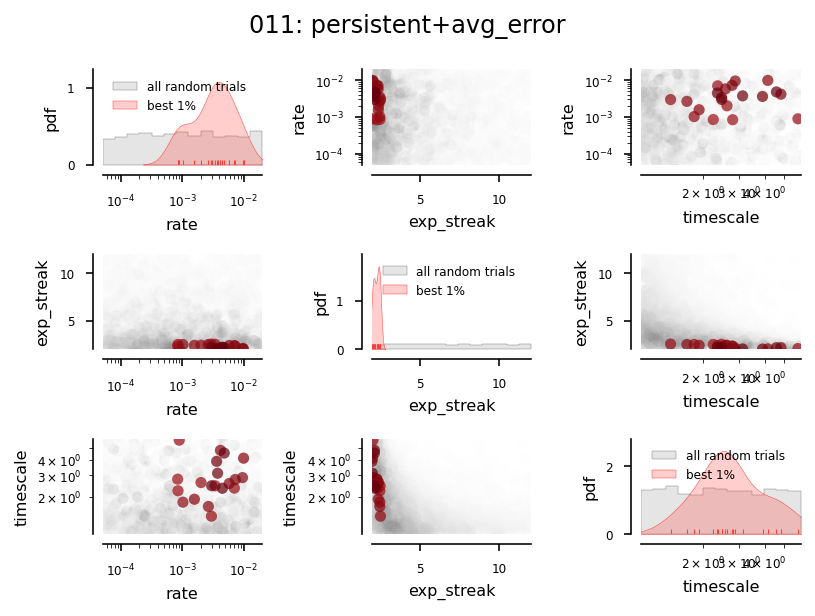

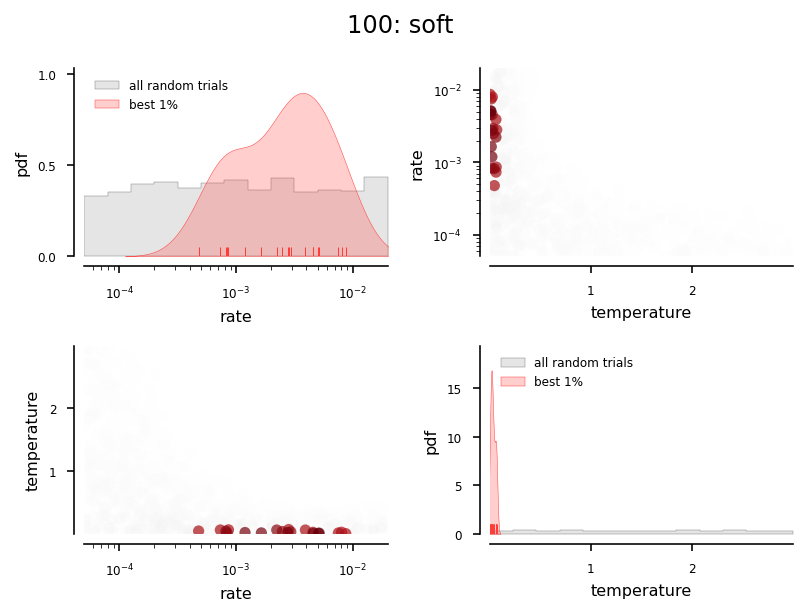

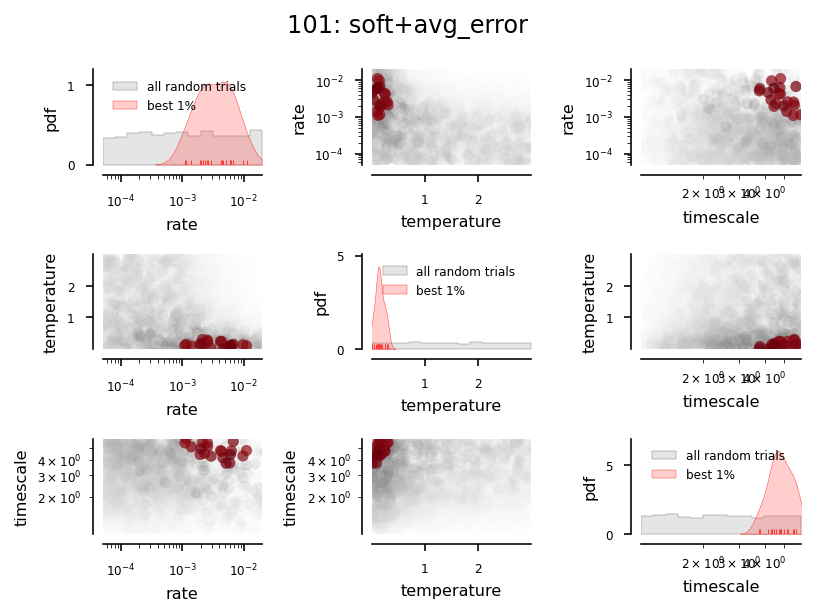

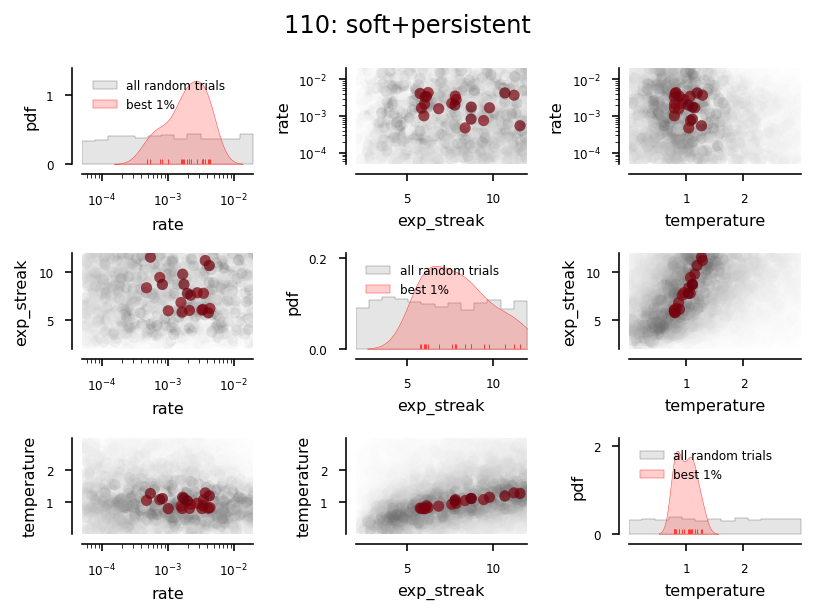

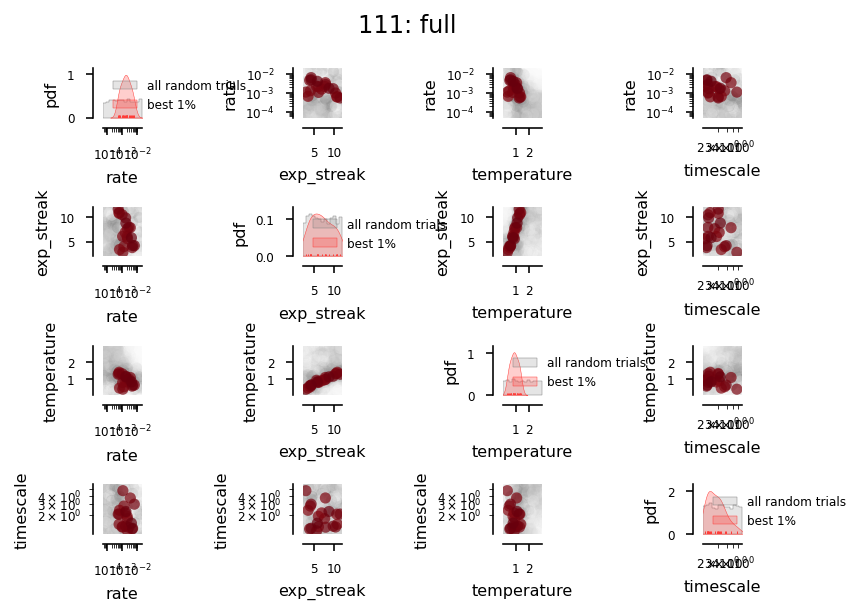

In [9]:
for key in results:
    # key_str = configurations[key]
    key_str = "".join(str(_) for _ in key)
    key_str_human = configurations_human[key]
    crt_results = results[key]

    fig, _ = make_summary_figure(
        crt_results,
        log_scale=["rate", "timescale"],
        fct_key="fct_good",
        vmin=0.0,
        vmax=1.0,
    )
    fig.savefig(os.path.join(fig_path, f"biowta_{key_str}_hyperopt_ar.pdf"))
    
    fig.suptitle(f"{key_str}: {key_str_human}")

In [10]:
summary = pd.DataFrame()
summary["mod_key"] = configurations_human.keys()
summary["mod_name"] = configurations_human.values()

for fct_type in ["fct", "fct_quantile", "fct_good"]:
    summary[f"best_{fct_type}"] = [
        np.max(results[cfg][fct_type]) for cfg in configurations_human
    ]

keys = results[(1, 1, 1)].keys()
chosen_fct = "fct_good"
for key in keys:
    if not key.startswith("fct"):
        key_values = []
        for cfg in configurations_human:
            crt_idx = np.argmax(results[cfg][chosen_fct])
            key_values.append(results[cfg][key][crt_idx])

        summary[f"{key}_at_best_{chosen_fct}"] = key_values

summary.sort_values(by=f"best_{chosen_fct}", ascending=False, inplace=True)

In [11]:
summary

,mod_key,mod_name,best_fct,best_fct_quantile,best_fct_good,rate_at_best_fct_good,exp_streak_at_best_fct_good,temperature_at_best_fct_good,timescale_at_best_fct_good,cepstral_order_at_best_fct_good
5,"(1, 1, 0)",soft+persistent,0.920596,0.612961,0.755,0.001992,7.794633,1.036228,1.000000,3
7,"(1, 1, 1)",full,0.924296,0.584462,0.730,0.004130,5.769690,0.808615,1.470822,3
1,"(0, 0, 1)",avg_error,0.930022,0.569311,0.700,0.004718,2.000000,0.000000,4.216198,3
6,"(1, 0, 1)",soft+avg_error,0.923721,0.543752,0.695,0.006080,2.000000,0.117712,4.438448,3
4,"(0, 1, 1)",persistent+avg_error,0.916421,0.533119,0.660,0.004826,2.154856,0.000000,4.566321,3
2,"(0, 1, 0)",persistent,0.855993,0.550343,0.515,0.001476,2.984215,0.000000,1.000000,3
0,"(0, 0, 0)",plain,0.722961,0.562611,0.165,0.001199,2.000000,0.000000,1.000000,3
3,"(1, 0, 0)",soft,0.721586,0.559948,0.150,0.005084,2.000000,0.011821,1.000000,3


In [12]:
mask = results[(1, 1, 0)]["fct"] >= 0.90
np.mean(mask)

0.0505

In [13]:
results[(1, 1, 0)].keys()

dict_keys(['fct', 'fct_quantile', 'fct_good', 'rate', 'exp_streak', 'temperature', 'timescale', 'cepstral_order'])

In [14]:
(np.min(results[(1, 1, 0)]["rate"][mask]), np.max(results[(1, 1, 0)]["rate"][mask]))

(0.0002906147606973583, 0.01187867927307873)

In [15]:
np.quantile(results[(1, 1, 0)]["rate"][mask], [0.025, 0.975])

array([0.00033829, 0.00929779])

In [16]:
(
    np.min(results[(1, 1, 0)]["temperature"][mask]),
    np.max(results[(1, 1, 0)]["temperature"][mask]),
)

(0.41302339422680523, 1.4171026571249494)

In [17]:
np.quantile(results[(1, 1, 0)]["temperature"][mask], [0.025, 0.975])

array([0.48789712, 1.33336044])